KIDNEY STONE DETECTION

In [2]:
# pip install numpy pandas matplotlib seaborn keras tensorflow opencv-python scikit-image scikit-learn gradio


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
import random
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2 
from skimage.feature import hog 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
import gradio as gr

s:\Python\KidneyStoneDetection\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
folder_path = "./CT_Images/Train"
filenames = []
categories = []

for category in os.listdir(folder_path):
    category_path = os.path.join(folder_path, category)
    
    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            filenames.append(os.path.join(category, filename))
            categories.append(category)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

<Axes: xlabel='category'>

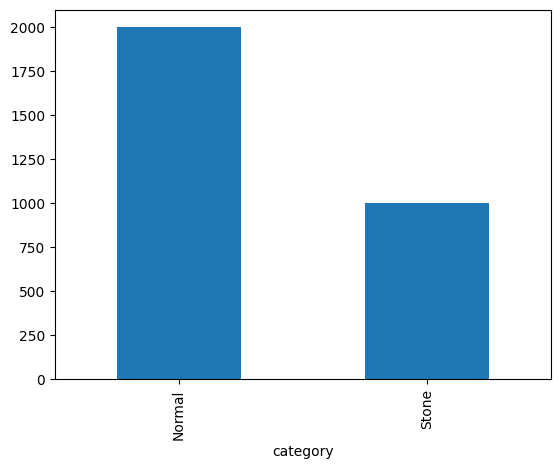

In [5]:
df['category'].value_counts().plot.bar()

CNN MODEL

In [6]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3) , activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('sigmoid'))

s:\Python\KidneyStoneDetection\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,637,506 (40.58 MB)

 Trainable params: 10,637,058 (40.58 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
earlystop = EarlyStopping(patience=10)

In [9]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

In [10]:
callbacks = [earlystop, learning_rate_reduction]

In [11]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [12]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./CT_Images/Train/", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15
)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./CT_Images/Train/", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15
)

Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.


In [16]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./CT_Images/Train/", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


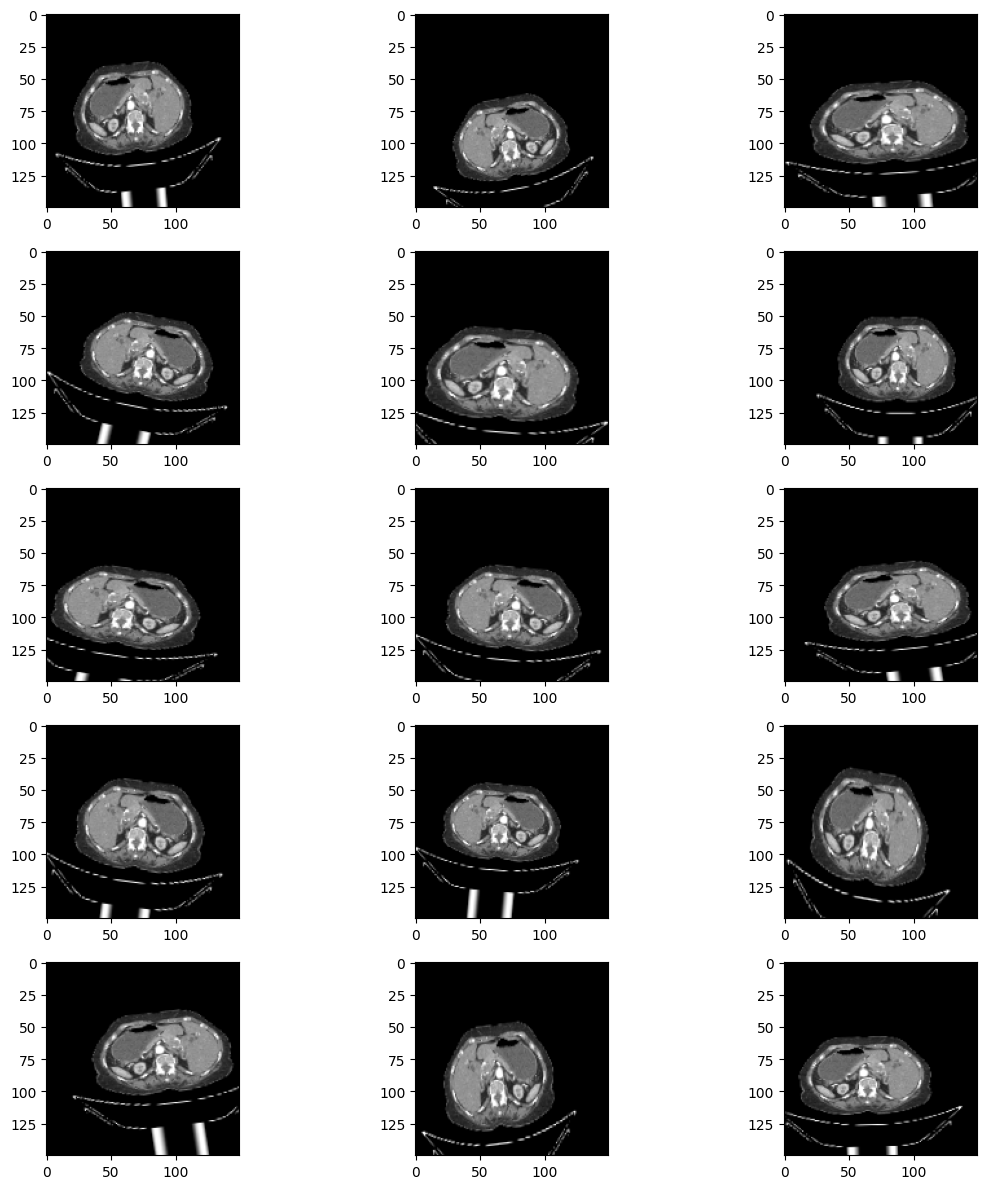

In [17]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()

Training

In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
history = model.fit(
    train_generator, 
    epochs=50,
    validation_data=validation_generator,
    # validation_steps=validate_df.shape[0]//15,
    # steps_per_epoch=train_df.shape[0]//15,
    callbacks=callbacks
)

Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 112s 690ms/step - accuracy: 0.8602 - loss: 0.3536 - val_accuracy: 0.8217 - val_loss: 0.4806 - learning_rate: 0.0010
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 110s 684ms/step - accuracy: 0.9010 - loss: 0.2661 - val_accuracy: 0.8600 - val_loss: 0.4595 - learning_rate: 0.0010
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 108s 668ms/step - accuracy: 0.9155 - loss: 0.2458 - val_accuracy: 0.5300 - val_loss: 1.3617 - learning_rate: 0.0010
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 99s 614ms/step - accuracy: 0.9016 - loss: 0.2338 - val_accuracy: 0.9683 - val_loss: 0.1442 - learning_rate: 0.0010
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 95s 587ms/step - accuracy: 0.9248 - loss: 0.2070 - val_accuracy: 0.8567 - val_loss: 0.3686 - learning_rate: 0.0010
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.9249 - loss: 0.1763
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
160/160 ━━━━━━━━━━━━━━━━━━━━ 123s 763ms/step - accuracy: 0

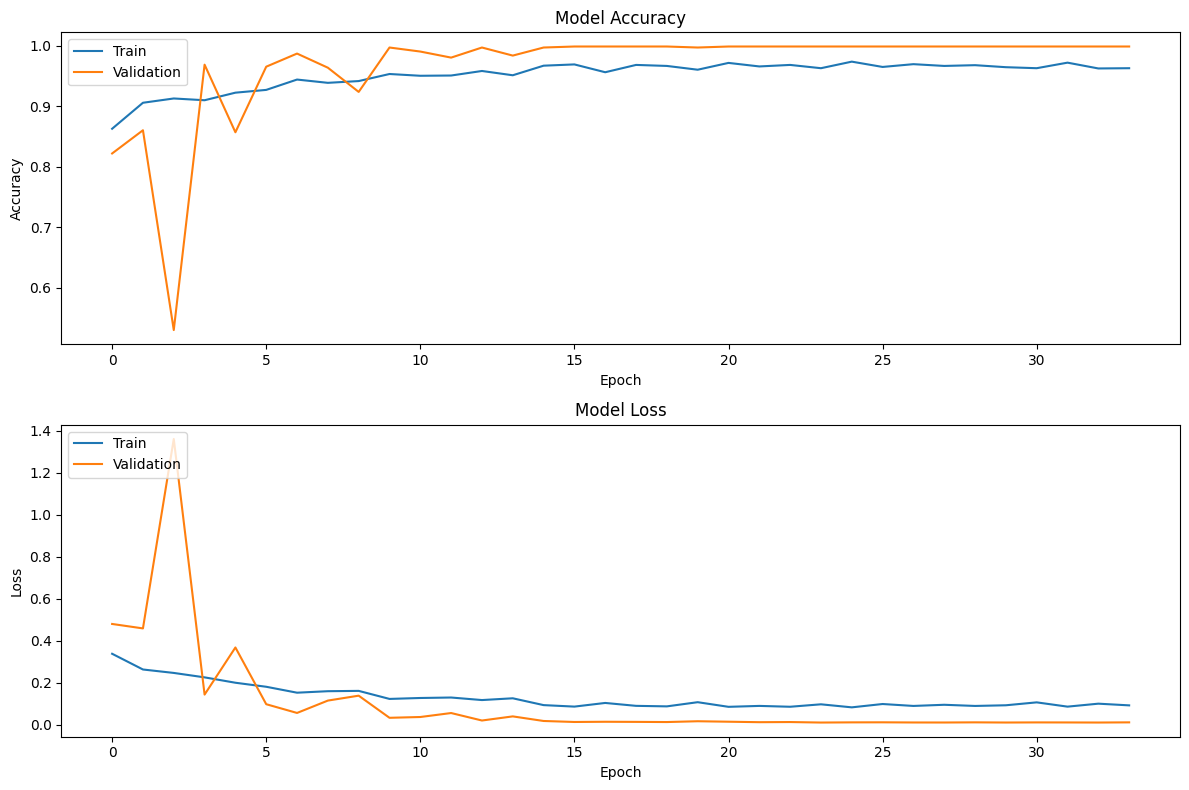

In [21]:
plt.figure(figsize=(12, 8)) 

plt.subplot(2, 1, 1) 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 1, 2) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [22]:
model.save('kidney_stone_detection_model.h5')

Testing

In [23]:
test_folder_path = "./CT_Images/Test"
test_filenames = []
test_categories = []

for category in os.listdir(test_folder_path):
    test_category_path = os.path.join(test_folder_path, category)
    
    if os.path.isdir(test_category_path):
        for filename in os.listdir(test_category_path):
            test_filenames.append(os.path.join(category, filename))
            test_categories.append(category)

test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': test_categories
})

In [24]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./CT_Images/Test/", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15,
    shuffle=False
)

Found 900 validated image filenames belonging to 2 classes.


In [27]:
steps = int(np.ceil(test_df.shape[0] / 15))

predict = model.predict(test_generator, steps=steps)

s:\Python\KidneyStoneDetection\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 235ms/step


In [28]:
test_df['predicted category'] = np.argmax(predict, axis=-1)

In [29]:
test_df['predicted category'] = test_df['predicted category'].replace({ 1: 'Stone', 0: 'Normal' })

In [30]:
test_df.head()

,filename,category,predicted category
0,Normal\Normal- (1001).jpg,Normal,Normal
1,Normal\Normal- (1002).jpg,Normal,Normal
2,Normal\Normal- (1003).jpg,Normal,Normal
3,Normal\Normal- (1004).jpg,Normal,Normal
4,Normal\Normal- (1005).jpg,Normal,Normal


In [31]:
model.evaluate(test_generator)

60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.9931 - loss: 0.0205


[0.03798060119152069, 0.9877777695655823]